<a href="https://colab.research.google.com/github/phycem/Quantum-Machine-Learning-/blob/main/Inspecting_circuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://docs.pennylane.ai/en/stable/introduction/inspecting_circuits.html

In [1]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 19.7 MB/s eta 0:00:00


In [7]:
import pennylane as qml
from pennylane import numpy as np

In [5]:
#Extracting properties of a circuit
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, diff_method='parameter-shift')
def circuit(x, y):
    qml.RX(x[0], wires=0)
    qml.Toffoli(wires=(0, 1, 2))
    qml.CRY(x[1], wires=(0, 1))
    qml.Rot(x[2], x[3], y, wires=0)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliX(1))

In [8]:
x = np.array([0.05, 0.1, 0.2, 0.3], requires_grad=True)
y = np.array(0.4, requires_grad=False)
specs_func = qml.specs(circuit)
specs_func(x, y)

{'resources': Resources(num_wires=3, num_gates=4, gate_types=defaultdict(<class 'int'>, {'RX': 1, 'Toffoli': 1, 'CRY': 1, 'Rot': 1}), depth=4, shots=0),
 'gate_sizes': defaultdict(int, {1: 2, 3: 1, 2: 1}),
 'gate_types': defaultdict(int, {'RX': 1, 'Toffoli': 1, 'CRY': 1, 'Rot': 1}),
 'num_operations': 4,
 'num_observables': 2,
 'num_diagonalizing_gates': 1,
 'num_used_wires': 3,
 'num_trainable_params': 4,
 'depth': 4,
 'num_device_wires': 4,
 'device_name': 'default.qubit',
 'expansion_strategy': 'gradient',
 'gradient_options': {},
 'interface': 'auto',
 'diff_method': 'parameter-shift',
 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift',
 'num_gradient_executions': 10}

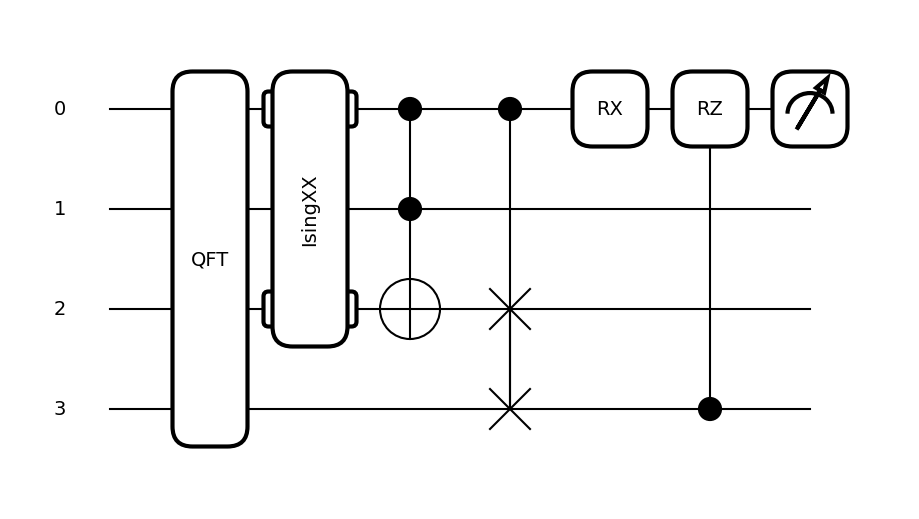

In [9]:
# Circuit drawing

dev = qml.device('lightning.qubit', wires=(0,1,2,3))

@qml.qnode(dev)
def circuit(x, z):
    qml.QFT(wires=(0,1,2,3))
    qml.IsingXX(1.234, wires=(0,2))
    qml.Toffoli(wires=(0,1,2))
    qml.CSWAP(wires=(0,2,3))
    qml.RX(x, wires=0)
    qml.CRZ(z, wires=(3,0))
    return qml.expval(qml.PauliZ(0))


fig, ax = qml.draw_mpl(circuit)(1.2345,1.2345)
fig.show()

In [10]:
print(qml.draw(circuit)(1.2345,1.2345))

0: ─╭QFT─╭IsingXX(1.23)─╭●─╭●─────RX(1.23)─╭RZ(1.23)─┤  <Z>
1: ─├QFT─│──────────────├●─│───────────────│─────────┤     
2: ─├QFT─╰IsingXX(1.23)─╰X─├SWAP───────────│─────────┤     
3: ─╰QFT───────────────────╰SWAP───────────╰●────────┤     


In [11]:
#Debugging with mid-circuit snapshots

dev = qml.device("default.qubit", wires=2)

@qml.qnode(dev, interface=None)
def circuit():
    qml.Snapshot()
    qml.Hadamard(wires=0)
    qml.Snapshot("very_important_state")
    qml.CNOT(wires=[0, 1])
    qml.Snapshot()
    return qml.expval(qml.PauliX(0))

In [12]:
qml.snapshots(circuit)()

{0: array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]),
 'very_important_state': array([0.70710678+0.j, 0.        +0.j, 0.70710678+0.j, 0.        +0.j]),
 2: array([0.70710678+0.j, 0.        +0.j, 0.        +0.j, 0.70710678+0.j]),
 'execution_results': array(0.)}

In [13]:
#Graph representation

import pennylane as qml
from pennylane import CircuitGraph

dev = qml.device('lightning.qubit', wires=(0,1,2,3))

@qml.qnode(dev)
def circuit():
    qml.Hadamard(0)
    qml.CNOT([1, 2])
    qml.CNOT([2, 3])
    qml.CNOT([3, 1])
    return qml.expval(qml.PauliZ(0))


circuit()
tape = circuit.qtape
ops = tape.operations
obs = tape.observables
g = CircuitGraph(ops, obs, tape.wires)

In [14]:
type(g.graph)

rustworkx.PyDiGraph

There is no edge between the Hadamard and the first CNOT, but between consecutive CNOT gates:

In [17]:
g.has_path(ops[0], ops[1])

False

In [16]:

g.has_path(ops[1], ops[3])

True

The Hadamard is connected to the observable, while the CNOT operators are not. The observable does not follow the Hadamard.

In [18]:
g.has_path(ops[0], obs[0])

True

In [19]:
g.has_path(ops[1], obs[0])

False

In [20]:
g.has_path(obs[0], ops[0])

False

Another way to construct the “causal” DAG of a circuit is to use the tape_to_graph() function used by the qcut module. This function takes a quantum tape and creates a MultiDiGraph instance from the networkx python package.

Using the above example, we get:

In [21]:
g2 = qml.transforms.qcut.tape_to_graph(tape)
type(g2)
for k, v in g2.adjacency():
   print(k, v)

Hadamard(wires=[0]) {expval(PauliZ(wires=[0])): {0: {'wire': 0}}}
CNOT(wires=[1, 2]) {CNOT(wires=[2, 3]): {0: {'wire': 2}}, CNOT(wires=[3, 1]): {0: {'wire': 1}}}
CNOT(wires=[2, 3]) {CNOT(wires=[3, 1]): {0: {'wire': 3}}}
CNOT(wires=[3, 1]) {}
expval(PauliZ(wires=[0])) {}


DAG of non-commuting ops

In [22]:
def circuit(x, y, z):
    qml.RX(x, wires=0)
    qml.RX(y, wires=0)
    qml.CNOT(wires=[1, 2])
    qml.RY(y, wires=1)
    qml.Hadamard(wires=2)
    qml.CRZ(z, wires=[2, 0])
    qml.RY(-y, wires=1)
    return qml.expval(qml.PauliZ(0))
dag_fn = qml.commutation_dag(circuit)
dag = dag_fn(np.pi / 4, np.pi / 3, np.pi / 2)

Nodes in the commutation DAG can be accessed via the get_nodes() method, returning a list of the form (ID, CommutationDAGNode):

In [23]:
nodes = dag.get_nodes()
nodes

NodeDataView({0: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7f9297287ee0>, 1: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7f9297287e20>, 2: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7f9297287ac0>, 3: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7f9297287f40>, 4: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7f9297272740>, 5: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7f92d71dcfa0>, 6: <pennylane.transforms.commutation_dag.CommutationDAGNode object at 0x7f92972724a0>}, data='node')

Specific nodes in the commutation DAG can be accessed via the get_node() method:

In [25]:
second_node = dag.get_node(2)
print(second_node)
print(second_node.op)
print(second_node.successors)
print(second_node.predecessors)

CNOT(wires=[1, 2])
[3, 4, 5, 6]
[]
